In [2]:
# Read csv, pick Arma 3 as the game to analyze and keep relevant columns.

import pandas as pd

df_full = pd.read_csv('data\\steam_reviews.csv', index_col=0)

df = df_full[df_full['app_name'] == 'Arma 3']
df = df.drop('review_votes', axis=1)

df.head()

,app_name,review_text,review_score
app_id,,,
107410,Arma 3,This is not a game for people who want fast ac...,1
107410,Arma 3,Oh man. Where to even begin with this one. It ...,1
107410,Arma 3,My first game on A3 brought me the most horrif...,1
107410,Arma 3,I spent several years in the army and I gotta ...,1
107410,Arma 3,Having accumulated over 13400 hours in-game wi...,1


In [3]:
# Check number of reviews per score

df.groupby(['app_name', 'review_score']).size()

app_name  review_score
Arma 3    -1               3600
           1              28708
dtype: int64

In [4]:
# Balance the df based on review_score to make the future models evaluation metrics clearer

g = df.groupby('review_score')
df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min())).reset_index(drop=True))
df.groupby(['app_name', 'review_score']).size()

########### kör denna efter texten bearbetats?
#def strLen(text):
#    return len(str(text))


#df['review_length'] = df['review_text'].apply(strLen)

#mean_len = df.groupby('review_score')['review_length'].mean()
#print(mean_len)


app_name  review_score
Arma 3    -1              3600
           1              3600
dtype: int64

Review mean length:
review_score
-1    424.478333
 1    241.997778
Name: review_length, dtype: float64


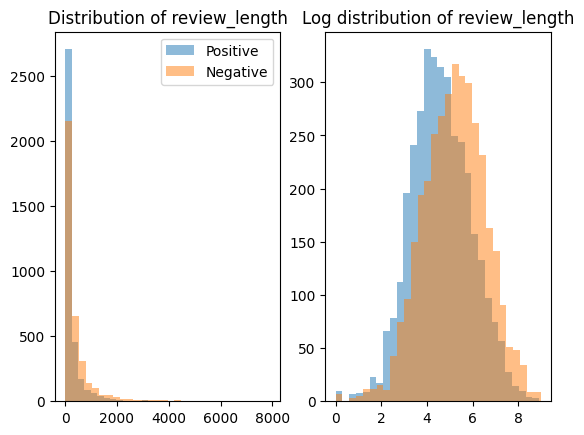

In [5]:
# Print the mean lengths of review_text per review_score.
# Plot the distributions of the lengths.

import matplotlib.pyplot as plt
import math

def len_str(text):
    return len(str(text))

df['review_length'] = df['review_text'].apply(len_str)

mean_review_length = df.groupby('review_score')['review_length'].mean()
print(f'Review mean length:\n{mean_review_length}')

df['review_length_log'] = df['review_length'].apply(math.log)

positive = df[df['review_score'] == 1]
negative = df[df['review_score'] == -1]

fig, axs = plt.subplots(1, 2)
axs[0].hist(positive['review_length'], alpha=0.5, bins=30, label='Positive')
axs[0].hist(negative['review_length'], alpha=0.5, bins=30, label='Negative')
axs[1].hist(positive['review_length_log'], alpha=0.5, bins=30, label='Positive')
axs[1].hist(negative['review_length_log'], alpha=0.5, bins=30, label='Negative')
axs[0].title.set_text('Distribution of review_length')
axs[1].title.set_text('Log distribution of review_length')
axs[0].legend()
plt.show()

In [6]:
# Credit for this cell to https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained

# Clean the column review_text and create a new column with the result.

import re
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df['review_clean'] = df['review_text'].apply(clean_text)
df.head()

,app_name,review_text,review_score,review_length,review_length_log,review_clean
0,Arma 3,"ARMA 3. a lot of walking, tactical, etc. fun....",-1,3946,8.280458,arma a lot of walking tactical etc fun but ...
1,Arma 3,Unless you can succesfuly install millions of ...,-1,155,5.043425,unless you can succesfuly install millions of ...
2,Arma 3,game is okay at best for the first few hours i...,-1,145,4.976734,game is okay at best for the first few hours i...
3,Arma 3,"After years of enjoying the Amra series, im sa...",-1,658,6.489205,after years of enjoying the amra series im sad...
4,Arma 3,it sucked m8 refunded.,-1,22,3.091042,it sucked refunded


In [7]:
# Credit for this cell to https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained

# Remove english stopwords from column 'review_clean' with the function remove_stopwords

import stopwords
stop_words = stopwords.get_stopwords('english')
more_stopwords = ['play', 'game', 'arma', 'will']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

df['review_clean'] = df['review_clean'].apply(remove_stopwords)
df.head()

,app_name,review_text,review_score,review_length,review_length_log,review_clean
0,Arma 3,"ARMA 3. a lot of walking, tactical, etc. fun....",-1,3946,8.280458,lot walking tactical etc fun ridiculously mind...
1,Arma 3,Unless you can succesfuly install millions of ...,-1,155,5.043425,unless can succesfuly install millions mods fi...
2,Arma 3,game is okay at best for the first few hours i...,-1,145,4.976734,okay best first hours modes tell stop updating...
3,Arma 3,"After years of enjoying the Amra series, im sa...",-1,658,6.489205,years enjoying amra series im sad finally chan...
4,Arma 3,it sucked m8 refunded.,-1,22,3.091042,sucked refunded


In [8]:
# Credit for this cell to https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained

# Stemm the words in column 'review_clean' with the function stemm_text

import nltk

stemmer = nltk.SnowballStemmer('english')

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

df['review_clean'] = df['review_clean'].apply(stemm_text)
df.head()

,app_name,review_text,review_score,review_length,review_length_log,review_clean
0,Arma 3,"ARMA 3. a lot of walking, tactical, etc. fun....",-1,3946,8.280458,lot walk tactic etc fun ridicul mind blow stup...
1,Arma 3,Unless you can succesfuly install millions of ...,-1,155,5.043425,unless can succesfuli instal million mod file ...
2,Arma 3,game is okay at best for the first few hours i...,-1,145,4.976734,okay best first hour mode tell stop updat deci...
3,Arma 3,"After years of enjoying the Amra series, im sa...",-1,658,6.489205,year enjoy amra seri im sad final chang review...
4,Arma 3,it sucked m8 refunded.,-1,22,3.091042,suck refund


In [9]:
# Create a column 'review_score_target' with 0 and 1 as values instead of
# -1 and 1 which can be found in 'review_score'.
# Create x and y variables to be used for modeling and double check that their
# sizes are equal.

def targetEncoded(toEncode):
    return 1 if toEncode == 1 else 0

df['review_score_target'] = df['review_score'].apply(targetEncoded)

x = df['review_clean']
y = df['review_score_target']

print(f'{len(x) = }, {len(y) = }')
df.groupby(['review_score', 'review_score_target']).size()

len(x) = 7200, len(y) = 7200


review_score  review_score_target
-1            0                      3600
 1            1                      3600
dtype: int64

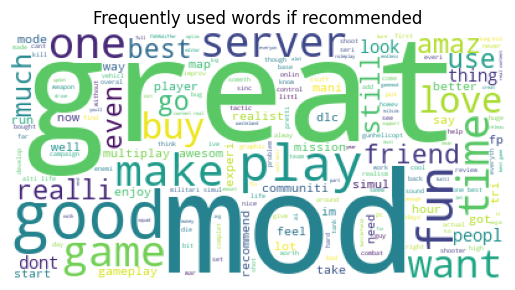

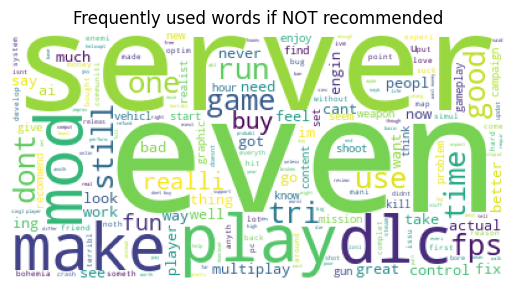

In [10]:
# Make wordclouds for words used in recommended reviews and not recommended reviews

from wordcloud import WordCloud

wc = WordCloud(background_color='white', max_words=200)

wc.generate(' '.join(text for text in df.loc[df['review_score_target'] == 1, 'review_clean']))
plt.axis('off')
plt.title('Frequently used words if recommended')
plt.imshow(wc)
plt.show()

wc.generate(' '.join(text for text in df.loc[df['review_score_target'] == 0, 'review_clean']))
plt.axis('off')
plt.title('Frequently used words if NOT recommended')
plt.imshow(wc)
plt.show()

In [11]:
# Split the data into train (75%) and test (25%) sets for the x and y variables.

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

print(f'{len(x_train) = }, {len(y_train) = }')
print(f'{len(x_test) = }, {len(y_test) = }')

len(x_train) = 5400, len(y_train) = 5400
len(x_test) = 1800, len(y_test) = 1800


In [21]:
from sklearn.feature_extraction.text import CountVectorizer

# Already filtered through stopwords above, but do it again just in case
vect = CountVectorizer(stop_words='english', ngram_range=(1,1), max_features=100)

# Creates a vocabulary dictionary of the top n most frequent words
vect.fit(x_train) 

# Transform the x variables to document term matrices based on the fitted CountVectorizer
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)
print(f'Example:\n(Review number, word)   Count\n{x_train_dtm[1]}')

Example:
(Review number, word)   Count
  (0, 12)	1
  (0, 15)	1
  (0, 31)	1
  (0, 34)	1
  (0, 56)	1
  (0, 76)	1


In [29]:
# TF-IDF gives higher weights to words that are 
# - rarer across the vocabulary
# - in shorter documents

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)

# Transform the counts to tf-idf values
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

#print(x_train_tfidf)
#print(vect.get_feature_names_out())
#print(tfidf_transformer.get_feature_names_out())

print(f'Example:\n(Review number, word)   TF-IDF\n{x_train_tfidf[1]}')

Example:
(Review number, word)   TF-IDF
  (0, 76)	0.46269548819526823
  (0, 56)	0.3223002084310852
  (0, 34)	0.38995860617054073
  (0, 31)	0.42683024534048747
  (0, 15)	0.422850657178416
  (0, 12)	0.41107299802943964


In [28]:
# Get weights of words
from sklearn.feature_extraction.text import TfidfVectorizer

#vect = TfidfVectorizer()
#tfidf_matrix = vect.fit_transform(x_train)
df = pd.DataFrame(x_train_tfidf.toarray())#, columns = vect.get_feature_names_out())
print(df)

#feature_array = np.array(tfidf.get_feature_names())
#tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

       0    1    2    3         4    5         6    7    8         9   ...  \
0     0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.000000  ...   
1     0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.000000  ...   
2     0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.000000  ...   
3     0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.000000  ...   
4     0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.000000  ...   
...   ...  ...  ...  ...       ...  ...       ...  ...  ...       ...  ...   
5395  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.000000  ...   
5396  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.000000  ...   
5397  0.0  0.0  0.0  0.0  0.000000  0.0  0.211866  0.0  0.0  0.000000  ...   
5398  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.240090  ...   
5399  0.0  0.0  0.0  0.0  0.176003  0.0  0.000000  0.0  0.0  0.139304  ...   

       90        91   92   93        94   95   96        97   9

In [35]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Train the model
# nb.fit(x_train_dtm, y_train) # gammal

nb.fit(x_train_tfidf, y_train)
#nb.fit(x_train_dtm, y_train)

y_pred_class = nb.predict(x_test_dtm)
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]
print(y_pred_prob)

[0.62063443 0.11576573 0.01305423 ... 0.41926331 0.99667248 0.74307856]


In [69]:
# change when set is balanced
null_accuracy = y_test.value_counts().head(1) / len(y_test)
print(null_accuracy)


review_score_target
0    0.508333
Name: count, dtype: float64
0.866616


108327

In [36]:
from sklearn import metrics
from sklearn.metrics import classification_report
print(metrics.accuracy_score(y_test, y_pred_class))
print(f'ROC: {metrics.roc_auc_score(y_test, y_pred_prob)}')
print(classification_report(y_test, y_pred_class))


print(f'confusion matrix: \n[TN FP\nFN TP]\n{metrics.confusion_matrix(y_test, y_pred_class)}')


0.72
ROC: 0.8051537037037036
              precision    recall  f1-score   support

           0       0.69      0.81      0.74       900
           1       0.77      0.63      0.69       900

    accuracy                           0.72      1800
   macro avg       0.73      0.72      0.72      1800
weighted avg       0.73      0.72      0.72      1800

confusion matrix: 
[TN FP
FN TP]
[[726 174]
 [330 570]]


In [60]:
import numpy as np

#print(list(zip(nb.feature_log_prob_[0], vect.get_feature_names())))
print(sorted(list(zip(nb.feature_log_prob_[0], tfidf_transformer.get_feature_names_out())), reverse=True))
print(sorted(list(zip(nb.feature_log_prob_[1], tfidf_transformer.get_feature_names_out())), reverse=True))



print(np.exp(-3.6))


[(-3.59775199584434, 'x36'), (-3.617240673460281, 'x51'), (-3.7847955252153795, 'x20'), (-3.7907768698622384, 'x11'), (-3.817174224570521, 'x47'), (-3.906502306410907, 'x81'), (-3.922191732899016, 'x23'), (-4.001677312984855, 'x19'), (-4.048329595788632, 'x78'), (-4.053628577685708, 'x31'), (-4.058611409509716, 'x39'), (-4.08035448307825, 'x72'), (-4.091803915236426, 'x14'), (-4.117863095488906, 'x61'), (-4.159741227306743, 'x13'), (-4.173551993476293, 'x90'), (-4.233729715361964, 'x91'), (-4.27363219608609, 'x76'), (-4.295500904201353, 'x86'), (-4.310903089936281, 'x6'), (-4.3455387346479695, 'x94'), (-4.348004174200508, 'x60'), (-4.35010525749332, 'x98'), (-4.3655389251596475, 'x55'), (-4.408733756783194, 'x34'), (-4.422005275595757, 'x63'), (-4.422488307982019, 'x64'), (-4.444413967874215, 'x33'), (-4.460174029391669, 'x69'), (-4.4891391263789835, 'x92'), (-4.530331676294755, 'x17'), (-4.544336527121658, 'x68'), (-4.549855827414625, 'x8'), (-4.55454040439915, 'x67'), (-4.57073302767

In [42]:
FP = x_test[(y_pred_class == 1) & (y_test == 0)]
FN = x_test[(y_pred_class == 0) & (y_test == 1)]

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


100%|██████████| 100/100 [06:08<00:00,  3.69s/it]


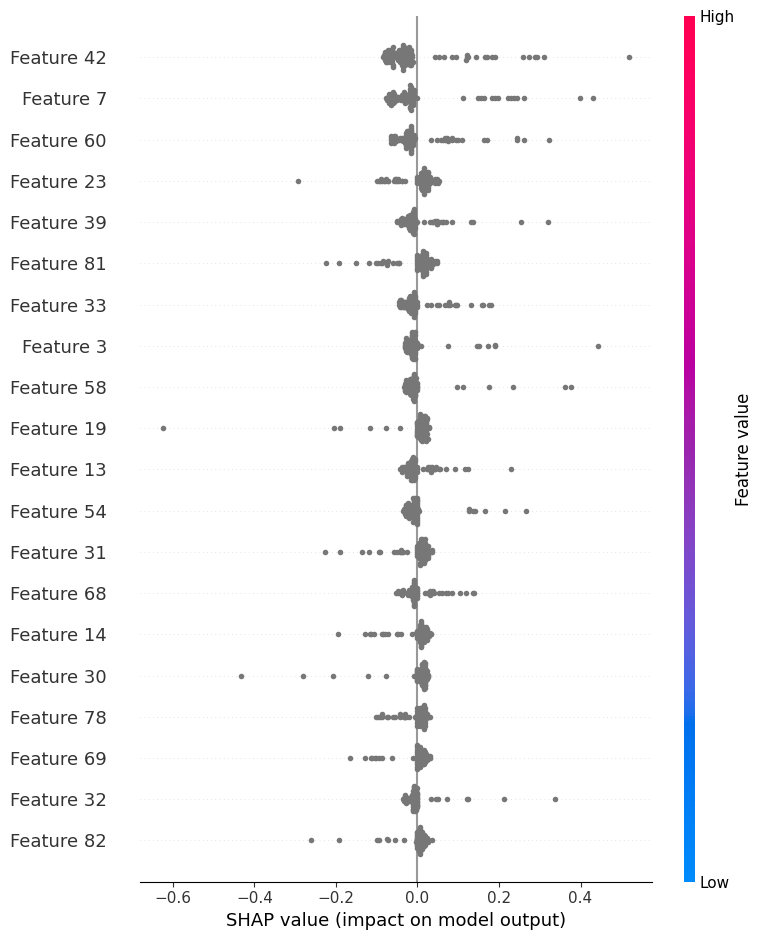

In [45]:
import shap
shap.initjs()
x_test_dtm_sample = shap.sample(x_train_dtm, 100)
explainer = shap.KernelExplainer(nb.predict, x_test_dtm_sample)
shap_values = explainer.shap_values(x_test_dtm_sample)
shap.summary_plot(shap_values, x_test_dtm_sample)

In [3]:
import numpy as np
print(np.__version__)

1.25.2


In [28]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', MultinomialNB())])

pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)

print(metrics.accuracy_score(y_test, y_pred_class))

print(metrics.confusion_matrix(y_test, y_pred_class))

print(f'ROC: {metrics.roc_auc_score(y_test, y_pred_prob)}')

print(classification_report(y_test, y_pred_class))

0.82
[[816  84]
 [240 660]]
ROC: 0.8058808641975308
              precision    recall  f1-score   support

           0       0.77      0.91      0.83       900
           1       0.89      0.73      0.80       900

    accuracy                           0.82      1800
   macro avg       0.83      0.82      0.82      1800
weighted avg       0.83      0.82      0.82      1800

